<h2 align = "center">Mod 2: Momentum in SGD</h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import latte
import latte.nn as nn
import latte.optim as optim
import latte.functional as F
import latte.utils.data as data

import lattevision as lv
import lattevision.datasets as dsets
import lattevision.transforms as T


In [2]:
mnist_root = './data/mnist'
mnist_transform = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

mnist_train = dsets.MNIST(mnist_root, train=True, transform=mnist_transform)
mnist_test = dsets.MNIST(mnist_root, train=False, transform=mnist_transform)

val_len = len(mnist_train) // 10
train_len = len(mnist_train) - val_len
mnist_train, mnist_val = data.random_split(mnist_train, [train_len, val_len])

train_batch_size = 128
test_batch_size = 512

train_loader = data.DataLoader(mnist_train, batch_size=train_batch_size, shuffle=True)
val_loader = data.DataLoader(mnist_val, batch_size=train_batch_size, shuffle=False)
test_loader = data.DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False)


In [3]:
class Model(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


model = Model()
model_mmt = Model()
criterion = nn.CrossEntropyLoss()
criterion_mmt = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0)
optimizer_mmt = optim.SGD(model_mmt.parameters(), lr=1e-2, momentum=0.9)


In [4]:
max_epochs = 20

train_losses = []
train_losses_mmt = []
train_accuracies = []
train_accuracies_mmt = []

val_losses = []
val_losses_mmt = []
val_accuracies = []
val_accuracies_mmt = []

for epoch in range(max_epochs):
    # Training
    epoch_loss = 0
    epoch_loss_mmt = 0
    epoch_accuracy = 0
    epoch_accuracy_mmt = 0
    epoch_batchs = 0

    for ii, (data, target) in enumerate(train_loader):
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        # Forward pass
        optimizer.zero_grad()
        optimizer_mmt.zero_grad()
        output = model(data)
        output_mmt = model_mmt(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data
        loss_mmt = criterion_mmt(output_mmt, target)
        epoch_loss_mmt += loss_mmt.data

        # Backward pass
        loss.backward()
        optimizer.step()
        loss_mmt.backward()
        optimizer_mmt.step()

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy
        accuracy_mmt = (output_mmt.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy_mmt += accuracy_mmt

    # Logging
    train_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    train_losses_mmt.append(np.round(epoch_loss_mmt / epoch_batchs, 4))
    train_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    train_accuracies_mmt.append(np.round(epoch_accuracy_mmt / epoch_batchs, 4))

    # Validation
    epoch_loss = 0
    epoch_loss_mmt = 0
    epoch_accuracy = 0
    epoch_accuracy_mmt = 0
    epoch_batchs = 0

    for data, target in val_loader:
        batch_size = data.shape[0]
        if batch_size != train_batch_size:
            continue
        epoch_batchs += 1

        data = latte.Tensor(data.reshape(batch_size, -1))
        target = latte.Tensor(target)

        output = model(data)
        output_mmt = model_mmt(data)

        # Compute loss
        loss = criterion(output, target)
        epoch_loss += loss.data
        loss_mmt = criterion_mmt(output_mmt, target)
        epoch_loss_mmt += loss_mmt.data

        # Compute accuracy
        accuracy = (output.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy += accuracy
        accuracy_mmt = (output_mmt.data.argmax(axis=1) == target.data).mean()
        epoch_accuracy_mmt += accuracy_mmt

    # Logging
    val_losses.append(np.round(epoch_loss / epoch_batchs, 4))
    val_losses_mmt.append(np.round(epoch_loss_mmt / epoch_batchs, 4))
    val_accuracies.append(np.round(epoch_accuracy / epoch_batchs, 4))
    val_accuracies_mmt.append(np.round(epoch_accuracy_mmt / epoch_batchs, 4))

print('No Momentum:')
print('Training')
print(f'\tLoss: {train_losses}')
print(f'\tAccuracy: {train_accuracies}')
print('Validation')
print(f'\tLoss: {val_losses}')
print(f'\tAccuracy: {val_accuracies}')
print('Momentum:')
print('Training')
print(f'\tLoss: {train_losses_mmt}')
print(f'\tAccuracy: {train_accuracies_mmt}')
print('Validation')
print(f'\tLoss: {val_losses_mmt}')
print(f'\tAccuracy: {val_accuracies_mmt}')


No Momentum:
Training
	Loss: [1.2242, 0.443, 0.3557, 0.3193, 0.2949, 0.2764, 0.2608, 0.2467, 0.2343, 0.2227, 0.2119, 0.2026, 0.1933, 0.1851, 0.1777, 0.1702, 0.1635, 0.1572, 0.1517, 0.1457]
	Accuracy: [0.7515, 0.8818, 0.8993, 0.9086, 0.9152, 0.9195, 0.9247, 0.9286, 0.9324, 0.9366, 0.9399, 0.9423, 0.9449, 0.9477, 0.9497, 0.9521, 0.9534, 0.9556, 0.9572, 0.9587]
Validation
	Loss: [0.5355, 0.3806, 0.3348, 0.3097, 0.2904, 0.2757, 0.2633, 0.2505, 0.2413, 0.2296, 0.2206, 0.213, 0.2043, 0.1961, 0.1892, 0.1837, 0.1792, 0.1735, 0.1689, 0.1628]
	Accuracy: [0.8696, 0.8962, 0.9064, 0.9116, 0.9184, 0.9234, 0.926, 0.9318, 0.9321, 0.9366, 0.9399, 0.9441, 0.945, 0.9465, 0.9479, 0.9498, 0.9509, 0.9533, 0.953, 0.9542]
Momentum:
Training
	Loss: [1.2185, 0.442, 0.355, 0.3194, 0.2954, 0.2769, 0.2611, 0.2466, 0.2339, 0.2221, 0.2112, 0.2016, 0.1924, 0.1842, 0.1769, 0.1695, 0.1628, 0.1567, 0.1512, 0.1453]
	Accuracy: [0.7339, 0.8821, 0.8997, 0.9079, 0.9146, 0.9196, 0.9253, 0.9288, 0.9328, 0.9365, 0.9403, 0.9422,

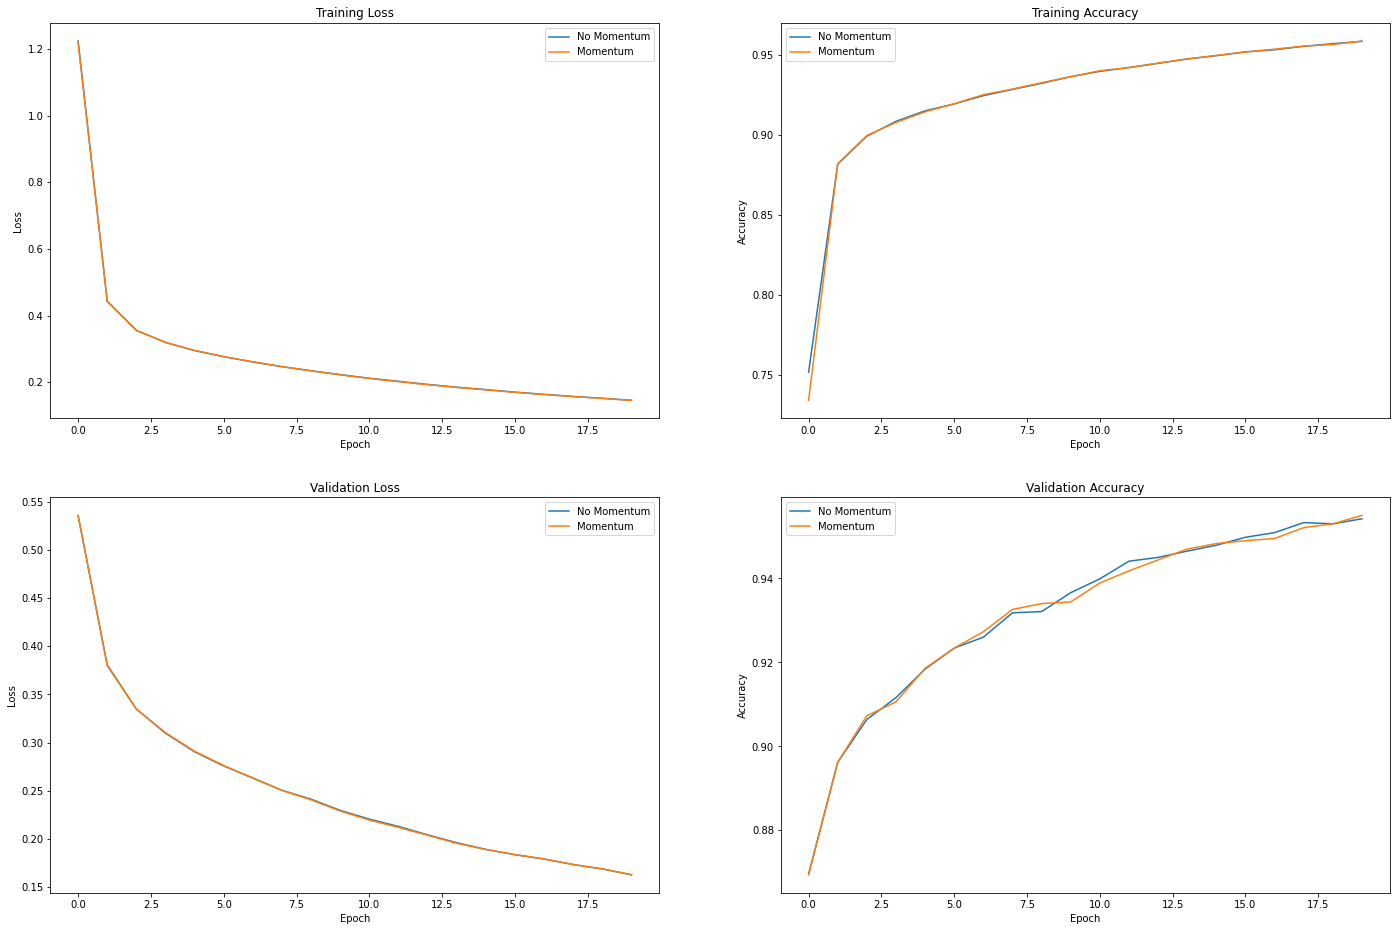

In [5]:
# Plot
plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='No Momentum')
plt.plot(train_losses_mmt, label='Momentum')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(train_accuracies, label='No Momentum')
plt.plot(train_accuracies_mmt, label='Momentum')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(val_losses, label='No Momentum')
plt.plot(val_losses_mmt, label='Momentum')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(val_accuracies, label='No Momentum')
plt.plot(val_accuracies_mmt, label='Momentum')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [6]:
# Test
correct = 0
correct_mmt = 0
total = 0
for data, target in test_loader:
    batch_size = data.shape[0]
    if batch_size != test_batch_size:
        continue

    data = latte.Tensor(data.reshape(batch_size, -1))
    target = latte.Tensor(target)

    output = model(data)
    output_mmt = model_mmt(data)
    correct += (output.data.argmax(axis=1) == target.data).sum()
    correct_mmt += (output_mmt.data.argmax(axis=1) == target.data).sum()
    total += target.shape[0]

print(f'Accuracy')
print(f'\tNo Momentum: {(correct / total): .4f}')
print(f'\tMomentum: {(correct_mmt / total): .4f}')


Accuracy
	No Momentum:  0.9577
	Momentum:  0.9572
